In [2]:
from google.colab import drive
import os

drive.mount('/content/drive/')

path = '/content/drive/MyDrive/Twitter Sentiment Analysis/'

Mounted at /content/drive/


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import rnnlibrary

import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU
from tensorflow.keras.layers import Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import accuracy_score

In [3]:
training_data = pd.read_csv(path + 'Datas/twitter_training.csv')
validation_data = pd.read_csv(path +'Datas/twitter_validation.csv')

training_data.columns = ['id', 'entity', 'sentiment', 'context']
validation_data.columns = ['id', 'entity', 'sentiment', 'context']

data = pd.concat(
    [training_data, validation_data],
    ignore_index=True,
)

data = data.drop(['id', 'entity'], axis=1)

df = data.copy()

data.tail()

,sentiment,context
75675,Irrelevant,⭐️ Toronto is the arts and culture capital of ...
75676,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
75677,Positive,Today sucked so it’s time to drink wine n play...
75678,Positive,Bought a fraction of Microsoft today. Small wins.
75679,Neutral,Johnson & Johnson to stop selling talc baby po...


In [4]:
data.isnull().any()

sentiment    False
context       True
dtype: bool

In [5]:
data.dropna(inplace=True)

In [6]:
data.shape

(74994, 2)

In [7]:
data.sentiment.value_counts()

Negative      22624
Positive      20931
Neutral       18393
Irrelevant    13046
Name: sentiment, dtype: int64

In [8]:
data['sentiment'].value_counts().index

Index(['Negative', 'Positive', 'Neutral', 'Irrelevant'], dtype='object')

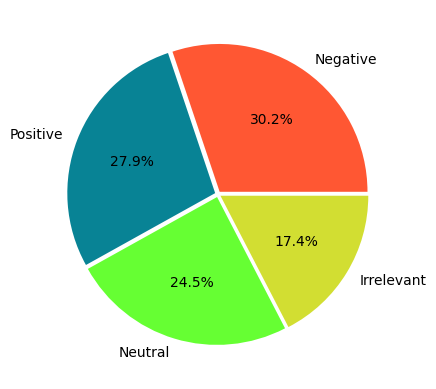

In [9]:
colors = [
    '#FF5733', '#088395', '#66FF33', '#D2DE32'
]

explodes = (0.02,0.02,0.02,0.02)

def plot_sentiment(data):

    value_counts = data['sentiment'].value_counts()
    labels = value_counts.index
    values = value_counts.values

    plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', explode=explodes)
    plt.show()

plot_sentiment(data)

In [10]:
sentiment_values = data['sentiment'].value_counts().index

def update_sentiment_values(sentiment):

    if sentiment == sentiment_values[0]:
        return 0
    elif sentiment == sentiment_values[1]:
        return 1
    elif sentiment == sentiment_values[2]:
        return 2
    elif sentiment == sentiment_values[3]:
        return 3
    else:
        return -1

data['sentiment'] = data['sentiment'].apply(update_sentiment_values)

In [11]:
>>> import nltk
>>> nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\90530\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
eng_stopwords = stopwords.words('english')

sample_text = data['context'][75675]
sample_text = re.sub('[^a-zA-Z]', ' ', sample_text)
sample_text = [word.lower() for word in sample_text.split() if word.lower() not in eng_stopwords]

In [13]:
# original text
data['context'][75675]

'⭐️ Toronto is the arts and culture capital of Canada, it’s no wonder! If you want to start planning, be sure to check out our GTA Real Estate market report for Fall 2020, it has all the info you need to finally make a move! blog.remax.ca/toronto-housin… twitter.com/kevinyoufool/s…'

In [14]:
# after preprocessing
' '.join(sample_text)

'toronto arts culture capital canada wonder want start planning sure check gta real estate market report fall info need finally make move blog remax ca toronto housin twitter com kevinyoufool'

In [15]:
data.head()

,sentiment,context
0,1,I am coming to the borders and I will kill you...
1,1,im getting on borderlands and i will kill you ...
2,1,im coming on borderlands and i will murder you...
3,1,im getting on borderlands 2 and i will murder ...
4,1,im getting into borderlands and i can murder y...


In [16]:
eng_stopwords = stopwords.words('english')

def preprocessing_context(context):
    context = re.sub('[^a-zA-Z]', ' ' ,context)
    context = [word.lower() for word in context.split() if word.lower() not in eng_stopwords]
    return ' '.join(context)

data['context'] = data['context'].apply(preprocessing_context)

data.head()

,sentiment,context
0,1,coming borders kill
1,1,im getting borderlands kill
2,1,im coming borderlands murder
3,1,im getting borderlands murder
4,1,im getting borderlands murder


In [17]:
y = data['sentiment']
X = data['context']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [18]:
tokenizer = Tokenizer(29000)

tokenizer.fit_on_texts(X)

X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

In [19]:
num_tokens = np.array([len(token) for token in X_train_token + X_test_token])

print('std', num_tokens.std())
print('mean', num_tokens.mean())

std 8.030352892805405
mean 11.253606955223084


In [20]:
max_token = int(num_tokens.mean()) + 2 * int(num_tokens.std())
max_token

27

In [21]:
X_train_tokenized_pad = pad_sequences(X_train_token, maxlen=max_token)
X_test_tokenized_pad = pad_sequences(X_test_token, maxlen=max_token)

X_train_tokenized_pad.shape, y_train.shape

((59995, 27), (59995,))

In [22]:
glove_path = path + '/Glove/glove.6B.100d.txt'

glove_embedding_matrix = {}

with open(glove_path, encoding='utf-8') as f:

    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embedding_matrix[word] = vector

embedding_matrix_dim = 100

embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_matrix_dim))

for word, index in tokenizer.word_index.items():
    vector = glove_embedding_matrix.get(word)

    if vector is not None:
        embedding_matrix[index] = vector

In [23]:
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [25]:
def loss_plot(model_history):

    plt.plot(model_history.history['loss'], label='training loss')
    plt.plot(model_history.history['val_loss'], label='validation loss')
    plt.legend(['loss', 'val_loss'], loc='upper right')
    plt.show() 

In [102]:
gru_accuracy_sig_a, gru_model_history_sig_a, gru_model_sig_a= rnnlibrary.rnn_model(
    rnn_layer='GRU', 
    max_token=max_token,
    input_dim=len(tokenizer.word_index) + 1 , 
    embedding_matrix=embedding_matrix, 
    units=(64, 32, 16, 8), epochs=25, hidden_activation='tanh',
    output_activation='sigmoid', optimizer='adam', loss_func='categorical_crossentropy', check_point_name='gru_model_sig_a', 
    use_es=True, train_data=X_train_tokenized_pad, 
    test_data=X_test_tokenized_pad,
    train_label=y_train_categorical, 
    test_label=y_test_categorical, 
    path_to_save_model=path
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 27, 100)           2964500   
                                                                 
 gru_17 (GRU)                (None, 27, 64)            31872     
                                                                 
 dropout_13 (Dropout)        (None, 27, 64)            0         
                                                                 
 gru_18 (GRU)                (None, 27, 32)            9408      
                                                                 
 dropout_14 (Dropout)        (None, 27, 32)            0         
                                                                 
 gru_19 (GRU)                (None, 27, 16)            2400      
                                                                 
 dropout_15 (Dropout)        (None, 27, 16)           

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1688/1688 [==============================] - 31s 18ms/step - loss: 1.0363 - accuracy: 0.5825 - val_loss: 0.9864 - val_accuracy: 0.6045
Epoch 3/25
1688/1688 [==============================] - 30s 18ms/step - loss: 0.9462 - accuracy: 0.6288 - val_loss: 0.9153 - val_accuracy: 0.6432
Epoch 4/25
1688/1688 [==============================] - 32s 19ms/step - loss: 0.8618 - accuracy: 0.6693 - val_loss: 0.8560 - val_accuracy: 0.6748
Epoch 5/25
1688/1688 [==============================] - 33s 19ms/step - loss: 0.7863 - accuracy: 0.7066 - val_loss: 0.8223 - val_accuracy: 0.6937
Epoch 6/25
1688/1688 [==============================] - 31s 18ms/step - loss: 0.7211 - accuracy: 0.7342 - val_loss: 0.7868 - val_accuracy: 0.7083
Epoch 7/25
1688/1688 [==============================] - 31s 18ms/step - loss: 0.6719 - accuracy: 0.7559 - val_loss: 0.7662 - val_accuracy: 0.7197
Epoch 8/25
1688/1688 [==============================] - 30s 18ms/step - loss: 0.6268 - accuracy: 0.7744 - val_loss: 0.7901 - val_accura

In [103]:
gru_accuracy_sig_a

0.7567170858383179

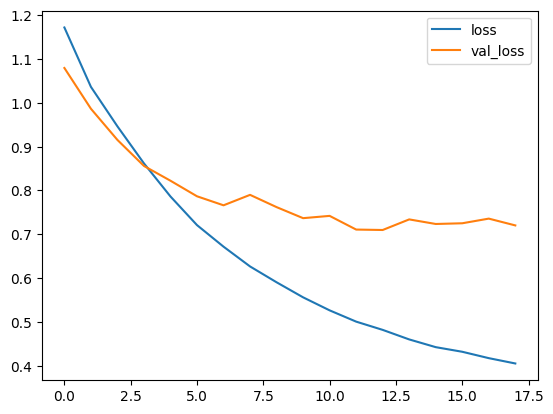

In [104]:
loss_plot(gru_model_history_sig_a)

In [105]:
gru_accuracy_sig_rms, gru_model_history_sig_rms, gru_model_sig_rms = rnnlibrary.rnn_model(
    rnn_layer='GRU', 
    max_token=max_token,
    input_dim=len(tokenizer.word_index) + 1 , 
    embedding_matrix=embedding_matrix, 
    units=(64, 32, 16, 8), epochs=25, hidden_activation='tanh',
    output_activation='sigmoid', optimizer='rmsprop', loss_func='categorical_crossentropy', check_point_name='gru_model_sig_rms', 
    use_es=True, train_data=X_train_tokenized_pad, 
    test_data=X_test_tokenized_pad,
    train_label=y_train_categorical, 
    test_label=y_test_categorical, 
    path_to_save_model=path
)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 27, 100)           2964500   
                                                                 
 gru_22 (GRU)                (None, 27, 64)            31872     
                                                                 
 dropout_17 (Dropout)        (None, 27, 64)            0         
                                                                 
 gru_23 (GRU)                (None, 27, 32)            9408      
                                                                 
 dropout_18 (Dropout)        (None, 27, 32)            0         
                                                                 
 gru_24 (GRU)                (None, 27, 16)            2400      
                                                                 
 dropout_19 (Dropout)        (None, 27, 16)           

In [106]:
gru_accuracy_sig_rms

0.768717885017395

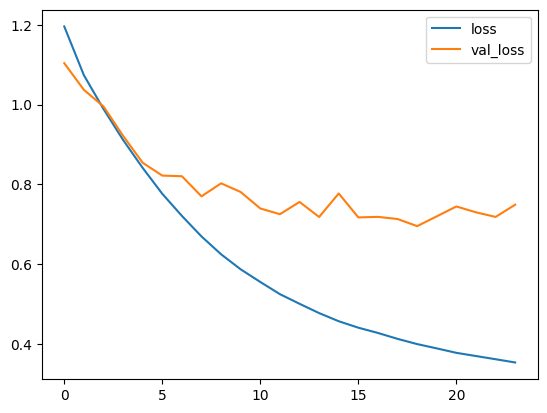

In [107]:
loss_plot(gru_model_history_sig_rms)

In [108]:
gru_accuracy_soft_a, gru_model_history_soft_a, gru_model_soft_a= rnnlibrary.rnn_model(
    rnn_layer='GRU', 
    max_token=max_token,
    input_dim=len(tokenizer.word_index) + 1 , 
    embedding_matrix=embedding_matrix, 
    units=(64, 32, 16, 8), epochs=25, hidden_activation='tanh',
    output_activation='softmax', optimizer='adam', loss_func='categorical_crossentropy', check_point_name='gru_model_soft_a', 
    use_es=True, train_data=X_train_tokenized_pad, 
    test_data=X_test_tokenized_pad,
    train_label=y_train_categorical, 
    test_label=y_test_categorical, 
    path_to_save_model=path
)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 27, 100)           2964500   
                                                                 
 gru_27 (GRU)                (None, 27, 64)            31872     
                                                                 
 dropout_21 (Dropout)        (None, 27, 64)            0         
                                                                 
 gru_28 (GRU)                (None, 27, 32)            9408      
                                                                 
 dropout_22 (Dropout)        (None, 27, 32)            0         
                                                                 
 gru_29 (GRU)                (None, 27, 16)            2400      
                                                                 
 dropout_23 (Dropout)        (None, 27, 16)           

In [109]:
gru_accuracy_soft_a

0.7544503211975098

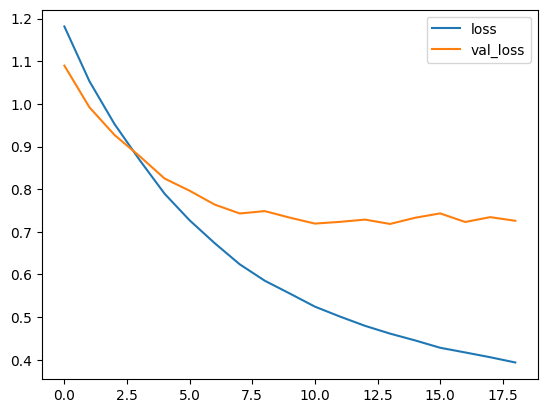

In [110]:
loss_plot(gru_model_history_soft_a)

In [111]:
gru_accuracy_soft_rms, gru_model_history_soft_rms, gru_model_soft_rms = rnnlibrary.rnn_model(
    rnn_layer='GRU', 
    max_token=max_token,
    input_dim=len(tokenizer.word_index) + 1 , 
    embedding_matrix=embedding_matrix, 
    units=(64, 32, 16, 8), epochs=25, hidden_activation='tanh',
    output_activation='softmax', optimizer='rmsprop', loss_func='categorical_crossentropy', check_point_name='gru_model_soft_rms', 
    use_es=True, train_data=X_train_tokenized_pad, 
    test_data=X_test_tokenized_pad,
    train_label=y_train_categorical, 
    test_label=y_test_categorical, 
    path_to_save_model=path
)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 27, 100)           2964500   
                                                                 
 gru_32 (GRU)                (None, 27, 64)            31872     
                                                                 
 dropout_25 (Dropout)        (None, 27, 64)            0         
                                                                 
 gru_33 (GRU)                (None, 27, 32)            9408      
                                                                 
 dropout_26 (Dropout)        (None, 27, 32)            0         
                                                                 
 gru_34 (GRU)                (None, 27, 16)            2400      
                                                                 
 dropout_27 (Dropout)        (None, 27, 16)           

In [112]:
gru_accuracy_soft_rms

0.7536502480506897

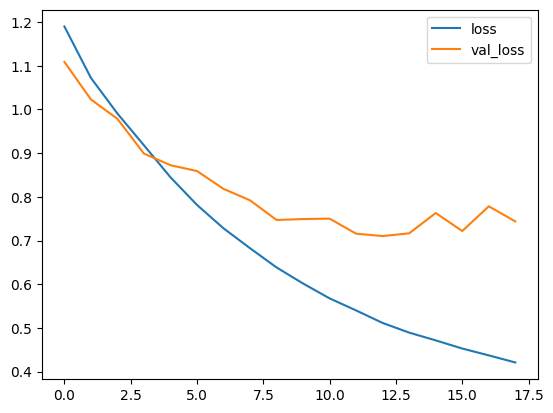

In [113]:
loss_plot(gru_model_history_soft_rms)

In [27]:
lstm_accuracy_sig_a, lstm_model_history_sig_a, lstm_model_sig_a = rnnlibrary.rnn_model(
    rnn_layer='LSTM', 
    max_token=max_token,
    input_dim=len(tokenizer.word_index) + 1 , 
    embedding_matrix=embedding_matrix, 
    units=(64, 32, 16, 8), epochs=25, hidden_activation='tanh',
    output_activation='sigmoid', optimizer='adam', loss_func='categorical_crossentropy', check_point_name='lstm_model_sig_a', 
    use_es=True, train_data=X_train_tokenized_pad, 
    test_data=X_test_tokenized_pad,
    train_label=y_train_categorical, 
    test_label=y_test_categorical, 
    path_to_save_model=path
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 27, 100)           2964500   
                                                                 
 gru (GRU)                   (None, 27, 64)            31872     
                                                                 
 dropout (Dropout)           (None, 27, 64)            0         
                                                                 
 gru_1 (GRU)                 (None, 27, 32)            9408      
                                                                 
 dropout_1 (Dropout)         (None, 27, 32)            0         
                                                                 
 gru_2 (GRU)                 (None, 27, 16)            2400      
                                                                 
 dropout_2 (Dropout)         (None, 27, 16)            0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1688/1688 [==============================] - 41s 16ms/step - loss: 1.1710 - accuracy: 0.5057 - val_loss: 1.0831 - val_accuracy: 0.5580
Epoch 2/25
1688/1688 [==============================] - 26s 16ms/step - loss: 1.0409 - accuracy: 0.5804 - val_loss: 0.9867 - val_accuracy: 0.6097
Epoch 3/25
1688/1688 [==============================] - 25s 15ms/step - loss: 0.9485 - accuracy: 0.6288 - val_loss: 0.9400 - val_accuracy: 0.6328
Epoch 4/25
1688/1688 [==============================] - 23s 14ms/step - loss: 0.8723 - accuracy: 0.6683 - val_loss: 0.8800 - val_accuracy: 0.6563
Epoch 5/25
1688/1688 [==============================] - 25s 15ms/step - loss: 0.7989 - accuracy: 0.6983 - val_loss: 0.8384 - val_accuracy: 0.6812
Epoch 6/25
1688/1688 [==============================] - 25s 15ms/step - loss: 0.7368 - accuracy: 0.7270 - val_loss: 0.8179 - val_accuracy: 0.6955
Epoch 7/25
1688/1688 [==============================] - 25s 15ms/step - loss: 0.6846 - accuracy: 0.7501 - val_loss: 0.7929 - val_accura

In [28]:
lstm_accuracy_sig_a

0.7604507207870483

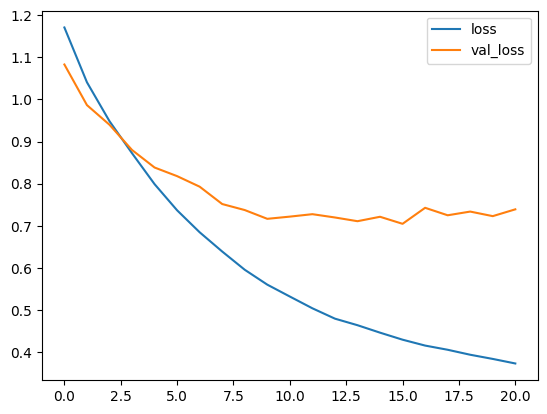

In [29]:
loss_plot(lstm_model_history_sig_a)

In [30]:
lstm_accuracy_sig_rms, lstm_model_history_sig_rms, lstm_model_sig_rms = rnnlibrary.rnn_model(
    rnn_layer='LSTM', 
    max_token=max_token,
    input_dim=len(tokenizer.word_index) + 1 , 
    embedding_matrix=embedding_matrix, 
    units=(64, 32, 16, 8), epochs=25, hidden_activation='tanh',
    output_activation='sigmoid', optimizer='rmsprop', loss_func='categorical_crossentropy', check_point_name='lstm_model_sig_rms', 
    use_es=True, train_data=X_train_tokenized_pad, 
    test_data=X_test_tokenized_pad,
    train_label=y_train_categorical, 
    test_label=y_test_categorical, 
    path_to_save_model=path
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 27, 100)           2964500   
                                                                 
 gru_5 (GRU)                 (None, 27, 64)            31872     
                                                                 
 dropout_4 (Dropout)         (None, 27, 64)            0         
                                                                 
 gru_6 (GRU)                 (None, 27, 32)            9408      
                                                                 
 dropout_5 (Dropout)         (None, 27, 32)            0         
                                                                 
 gru_7 (GRU)                 (None, 27, 16)            2400      
                                                                 
 dropout_6 (Dropout)         (None, 27, 16)           

In [31]:
lstm_accuracy_sig_rms

0.7657843828201294

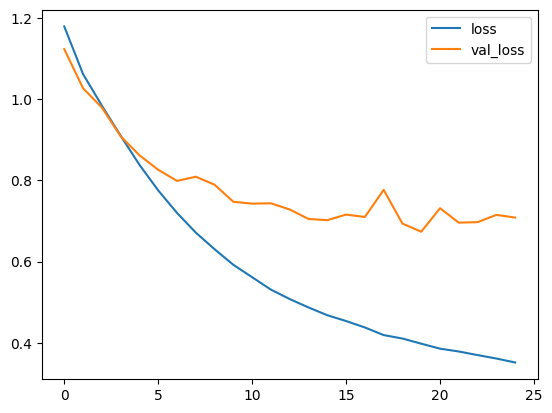

In [32]:
loss_plot(lstm_model_history_sig_rms)

In [33]:
lstm_accuracy_soft_a, lstm_model_history_soft_a, lstm_model_soft_a = rnnlibrary.rnn_model(
    rnn_layer='LSTM', 
    max_token=max_token,
    input_dim=len(tokenizer.word_index) + 1 , 
    embedding_matrix=embedding_matrix, 
    units=(64, 32, 16, 8), epochs=25, hidden_activation='tanh',
    output_activation='softmax', optimizer='adam', loss_func='categorical_crossentropy', check_point_name='lstm_model_soft_a', 
    use_es=True, train_data=X_train_tokenized_pad, 
    test_data=X_test_tokenized_pad,
    train_label=y_train_categorical, 
    test_label=y_test_categorical, 
    path_to_save_model=path
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 27, 100)           2964500   
                                                                 
 gru_10 (GRU)                (None, 27, 64)            31872     
                                                                 
 dropout_8 (Dropout)         (None, 27, 64)            0         
                                                                 
 gru_11 (GRU)                (None, 27, 32)            9408      
                                                                 
 dropout_9 (Dropout)         (None, 27, 32)            0         
                                                                 
 gru_12 (GRU)                (None, 27, 16)            2400      
                                                                 
 dropout_10 (Dropout)        (None, 27, 16)           

In [34]:
lstm_accuracy_soft_a

0.7712514400482178

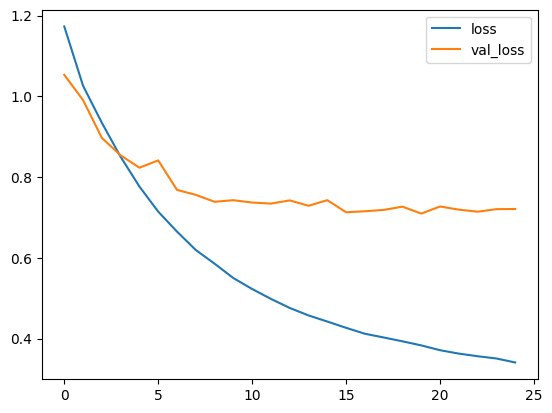

In [35]:
loss_plot(lstm_model_history_soft_a)

In [36]:
lstm_accuracy_soft_rms, lstm_model_history_soft_rms, lstm_model_soft_rms = rnnlibrary.rnn_model(
    rnn_layer='LSTM', 
    max_token=max_token,
    input_dim=len(tokenizer.word_index) + 1 , 
    embedding_matrix=embedding_matrix, units=(64, 32, 16, 8), epochs=25, hidden_activation='tanh',
    output_activation='softmax', optimizer='rmsprop', loss_func='categorical_crossentropy', 
    check_point_name='lstm_model_soft_rms',
    use_es=True, train_data=X_train_tokenized_pad, 
    test_data=X_test_tokenized_pad,
    train_label=y_train_categorical, 
    test_label=y_test_categorical, 
    path_to_save_model=path
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 27, 100)           2964500   
                                                                 
 gru_15 (GRU)                (None, 27, 64)            31872     
                                                                 
 dropout_12 (Dropout)        (None, 27, 64)            0         
                                                                 
 gru_16 (GRU)                (None, 27, 32)            9408      
                                                                 
 dropout_13 (Dropout)        (None, 27, 32)            0         
                                                                 
 gru_17 (GRU)                (None, 27, 16)            2400      
                                                                 
 dropout_14 (Dropout)        (None, 27, 16)           

In [37]:
lstm_accuracy_soft_rms

0.7657843828201294

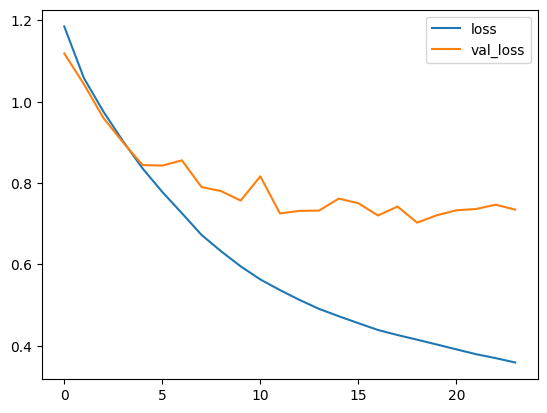

In [38]:
loss_plot(lstm_model_history_soft_rms)